In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from influxdb import *
import datetime
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse
import statistics

In [4]:
df = pd.read_excel(r'C:\Users\u22v09\Desktop\Data_7_14.xlsx')
df = df.rename(columns = {'Unnamed: 0':'time'}).set_index('time')
df.index.freq = 'H'

In [5]:
df[df['EM4'] < 0] = 0

In [6]:
df.head()

,EM4
time,
2020-06-14 11:00:00,26.0
2020-06-14 12:00:00,111.0
2020-06-14 13:00:00,120.0
2020-06-14 14:00:00,27.0
2020-06-14 15:00:00,109.0


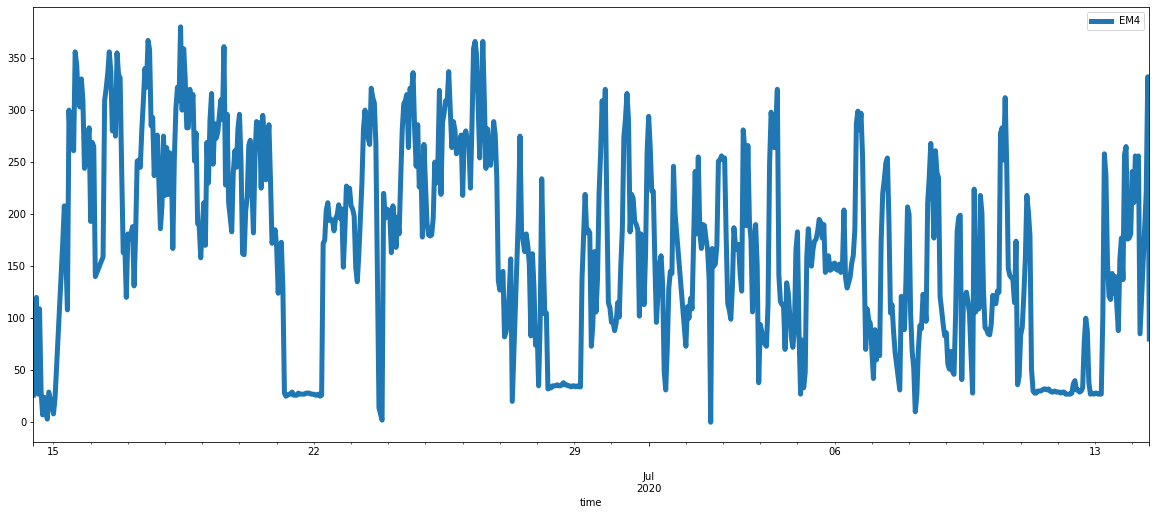

In [7]:
df.plot(figsize = (20,8), lw = 5)

In [8]:
result = seasonal_decompose(df['EM4'], model='additive')
# result.plot()
# plt.show()

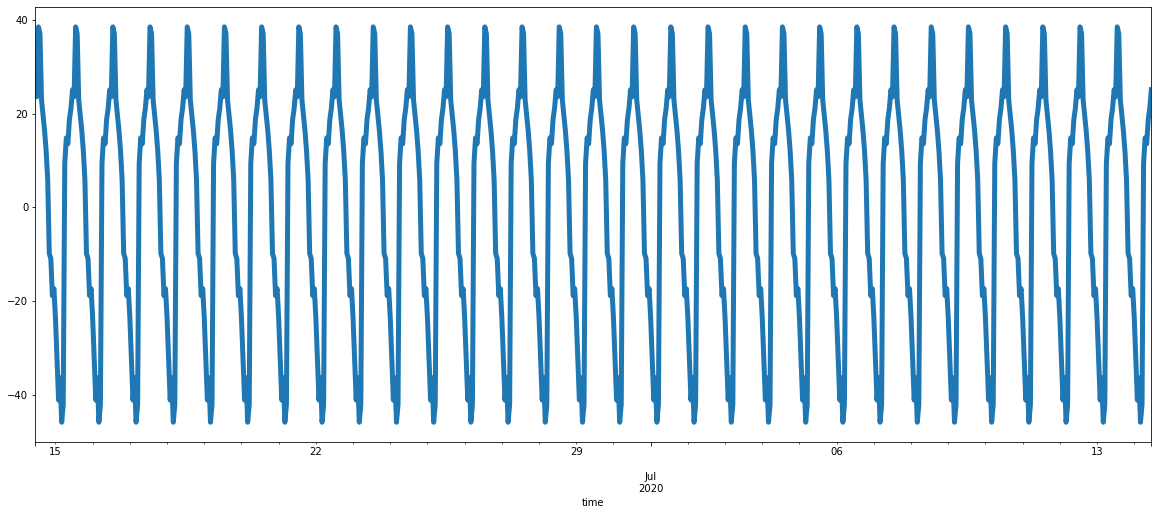

In [9]:
result.seasonal.plot(figsize = (20,8), lw = 5)

In [10]:
EM4 = df.copy()

In [11]:
from statsmodels.tsa.stattools import adfuller
result_l = adfuller(EM4['EM4'])
print('ADF Statistic: %f' % result_l[0])
print('p-value: %.12f' % result_l[1])
print('Critical Values:')
for key, value in result_l[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.695342
p-value: 0.004179153621
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


In [12]:
len(EM4)

721

In [13]:
train = EM4[:700]
test = EM4[700:]

In [27]:
import warnings
warnings.filterwarnings('ignore')
x = 12
#y = auto_arima(train, trace = True, seasonal = True, m = x)
y = auto_arima(EM4, start_p = 1, start_q = 1, max_p = 6, max_q = 6, 
               m = 12, start_P = 0, seasonal = True, d = 1, D = 1, 
               trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=7580.092, BIC=7602.904, Time=2.109 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=8024.706, BIC=8033.831, Time=0.038 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=7832.563, BIC=7850.813, Time=1.065 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=7568.873, BIC=7587.123, Time=1.117 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=8022.708, BIC=8027.270, Time=0.024 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=7952.022, BIC=7970.272, Time=1.042 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=7537.149, BIC=7564.524, Time=6

In [28]:
y.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  721
Model:             SARIMAX(1, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood               -3759.079
Date:                                 Tue, 21 Jul 2020   AIC                           7532.157
Time:                                         15:41:48   BIC                           7564.094
Sample:                                              0   HQIC                          7544.496
                                                 - 721                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0017      0.002     -0.740      0.459      -0.006       0.003
ar.L1          0.8447      0.027     31.566      0.000       0.792       0.897
ma.L1         -0.9984      0.067    -14.860      0.000      -1.130      -0.867
ar.S.L12      -0.9977      0.022    -45.418      0.000      -1.041      -0.955
ma.S.L12      -0.0112     10.529     -0.001      0.999     -20.648      20.625
ma.S.L24      -0.9888     10.383     -0.095      0.924     -21.338      19.361
sigma2      2189.8218    2.3e+04      0.095      0.924   -4.29e+04    4.73e+04
===================================================================================
Ljung-Box (Q):                       63.51   Jarque-Bera (JB):               139.38
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             0.09
Prob(H) (two-sided):                  0.82   Kurtosis:                         5.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
y.seasonal_order

(1, 1, 2, 12)

In [15]:
RMSE = []
m = 0
for i in range(82,len(EM4),10):
    EM4_new = EM4.iloc[m:i]
    train = EM4_new[0 : -10]
    test = EM4_new[-11:]
    yhat = test.copy()
    m=i-72
    import warnings
    warnings.filterwarnings('ignore')
    x = 12
#     y = auto_arima(train, trace = True, seasonal = True, m = x)
    y = auto_arima(EM4, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
    print(y.aic())
    order = list(y.order)
    seasonal_order = list(y.seasonal_order)
    a = len(test)
    model = SARIMAX(train, order = order, seasonal_order = seasonal_order, typ = 'levels').fit(disp = False, transparams = False, trend = 'c', solver = 'nm')
    yhat['predictions'] = model.forecast(a)
#     yhat['rms'] = sqrt(mean_squared_error(test.EM4, yhat['predictions']))
    plt.figure(figsize=(20,8))
#     plt.plot(EM4['EM4'])
    plt.plot(train['EM4'], label='Train', lw = 4, color = 'grey')
    plt.plot(test['EM4'], label='Train', lw = 4, color = 'blue')
    plt.plot(yhat['predictions'], label='Predicted', lw = 4, color = 'red')
    plt.legend(loc='best')
    plt.show()
#     r = yhat['rms'].mean()
#     RMSE.append(r)
#     print(yhat['rms'].mean())
    
# print(RMSE)
#     print(yhat['predictions'])

NameError: name 'n' is not defined

In [ ]:
statistics.mean(RMSE)